In [1]:
import pandas as pd
import os
import re
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import statsmodels.api as sm
import numpy as np
from torch.utils.data import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.model_selection import TimeSeriesSplit
import transformers
import torch.nn as nn
from transformers import RobertaModel
import torch.nn.functional as F

### Enviro Setup

In [ ]:
torch.cuda.set_device(0)  # Use GPU 0

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"

### File Prep - First Time ONLY

In [ ]:
tar_path = './data/UNGDC_1946-2023.tgz'
extract_path = './data/UNGDC_1946-2023/'

with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

KeyboardInterrupt: 

### Data Import - Local

In [ ]:
vdem_df = pd.read_csv('./data/V-Dem-CY-Full+Others-v14.csv')

C:\Users\maxla\AppData\Local\Temp\ipykernel_29540\952016332.py:1: DtypeWarning: Columns (364,365,366,399,415,804,836,837,924,1240,1257,1486,3094,3168,3169,3341,3342,3344,3345,3347,3350,3352) have mixed types. Specify dtype option on import or set low_memory=False.
  vdem_df = pd.read_csv('./data/V-Dem-CY-Full+Others-v14.csv')


In [ ]:
print(vdem_df.head())
print(vdem_df.info())

  country_name country_text_id  country_id  year historical_date  project  \
0       Mexico             MEX           3  1789      1789-12-31        1   
1       Mexico             MEX           3  1790      1790-12-31        1   
2       Mexico             MEX           3  1791      1791-12-31        1   
3       Mexico             MEX           3  1792      1792-12-31        1   
4       Mexico             MEX           3  1793      1793-12-31        1   

   historical                  histname  codingstart  codingend  ...  \
0           1  Viceroyalty of New Spain         1789       2023  ...   
1           1  Viceroyalty of New Spain         1789       2023  ...   
2           1  Viceroyalty of New Spain         1789       2023  ...   
3           1  Viceroyalty of New Spain         1789       2023  ...   
4           1  Viceroyalty of New Spain         1789       2023  ...   

   e_mipopula  e_miurbani  e_pefeliex  e_wb_pop  e_pechmor  e_miinteco  \
0         NaN         NaN     

In [ ]:
base_dir = './data/UNGDC_1946-2023/TXT'

speeches = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.txt'):
            # The expected naming pattern is: COUNTRY_SESSION_YEAR.txt
            # e.g., USA_75_2020.txt
            match = re.match(r"([A-Z]{3})_(\d{1,3})_(\d{4})\.txt", file)
            if match:
                country, session, year = match.groups()
            else:
                continue

            file_path = os.path.join(root, file)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    text = f.read()
            except UnicodeDecodeError as e:
                print(f"Decoding error in {file_path}: {e}")
                continue

            speeches.append({
                'Country': country,
                'Session': int(session),
                'Year': int(year),
                'Text': text,
            })

df_speeches = pd.DataFrame(speeches)
print(df_speeches.head())

  Country  Session  Year                                               Text
0     ARG        1  1946  At the resumption of the first session of the ...
1     AUS        1  1946  The General Assembly of the United Nations is ...
2     BEL        1  1946  The\tprincipal organs of the United Nations ha...
3     BLR        1  1946  As more than a year has elapsed since the Unit...
4     BOL        1  1946  Coming to this platform where so many distingu...


In [ ]:
df_speeches['Year'] = df_speeches['Year'].astype(int)
vdem_df['year'] = vdem_df['year'].astype(int)

In [ ]:
df = pd.merge(
    df_speeches,
    vdem_df,
    left_on=['Country', 'Year'],
    right_on=['country_text_id', 'year'],
    how='left'
)

# Please note that there are some NaN in the year etc (about 40 for year). See if is issue?

### Data Clearning/Eng

In [ ]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.dropna(subset=["v2x_polyarchy"])
df = df.sort_values(["Country", "Year"])

### EDA

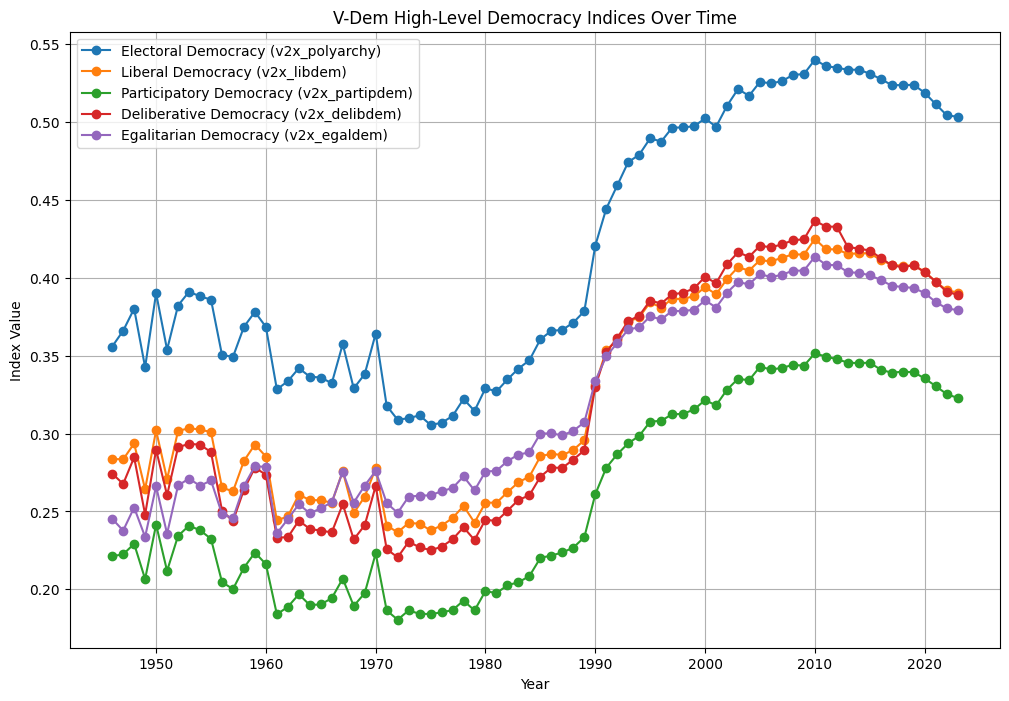

In [ ]:
indices = {
    'Electoral Democracy (v2x_polyarchy)': 'v2x_polyarchy',
    'Liberal Democracy (v2x_libdem)': 'v2x_libdem',
    'Participatory Democracy (v2x_partipdem)': 'v2x_partipdem',
    'Deliberative Democracy (v2x_delibdem)': 'v2x_delibdem',
    'Egalitarian Democracy (v2x_egaldem)': 'v2x_egaldem'
}

df_yearly = df.groupby('Year')[list(indices.values())].mean().reset_index()

plt.figure(figsize=(12, 8))

for label, col in indices.items():
    plt.plot(df_yearly['Year'], df_yearly[col], marker='o', label=label)

plt.xlabel('Year')
plt.ylabel('Index Value')
plt.title('V-Dem High-Level Democracy Indices Over Time')
plt.legend()
plt.grid(True)
plt.show()

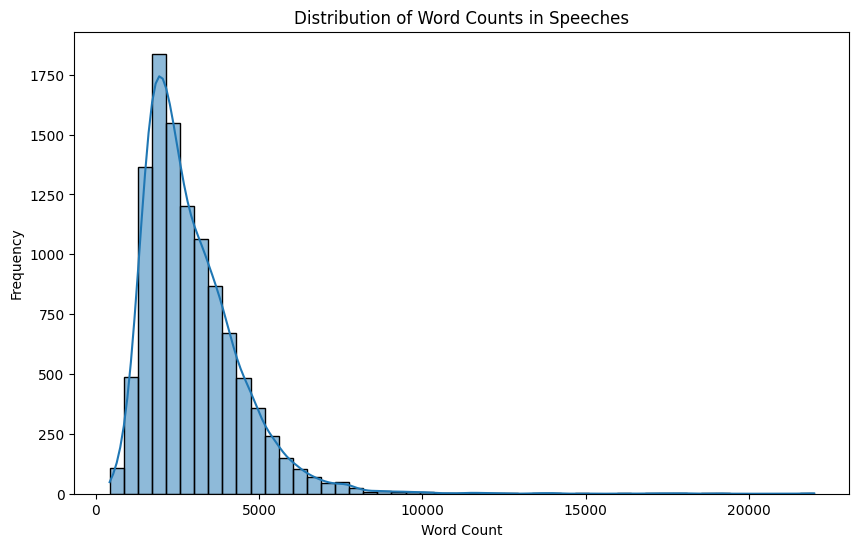

In [ ]:
df['word_count'] = df['Text'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Speeches")
plt.show()

100%|██████████| 10747/10747 [01:57<00:00, 91.33it/s] 


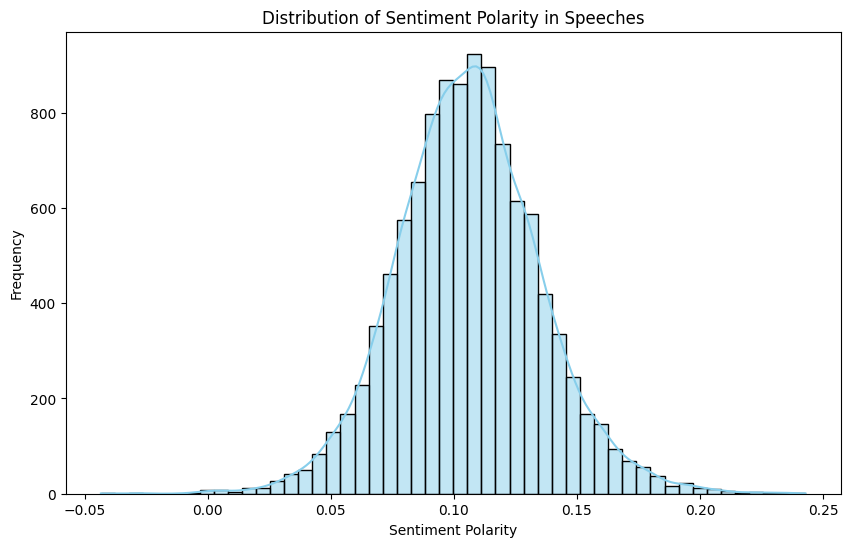

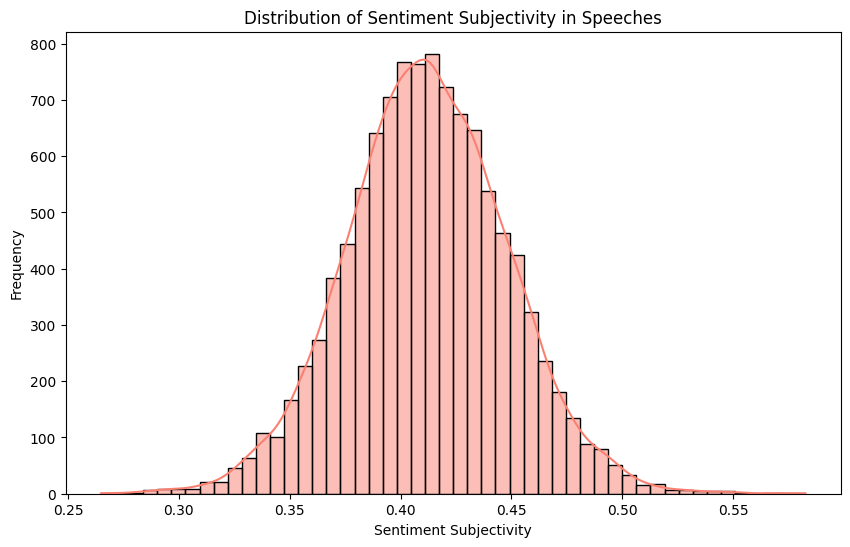

In [ ]:
def compute_sentiment(text):
    try:
        text = str(text)
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except Exception as e:
        print(f"Error in processing text: {e}")
        return 0.0, 0.0

texts = df['Text'].tolist()

with ThreadPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(compute_sentiment, texts), total=len(texts)))

polarities, subjectivities = zip(*results)

# Plot the distribution of sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(polarities, bins=50, kde=True, color='skyblue')
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Polarity in Speeches")
plt.show()

# Plot the distribution of sentiment subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(subjectivities, bins=50, kde=True, color='salmon')
plt.xlabel("Sentiment Subjectivity")
plt.ylabel("Frequency")
plt.title("Distribution of Sentiment Subjectivity in Speeches")
plt.show()

In [ ]:
temp_df = df.copy()
temp_df['sentiment_polarity'] = polarities
temp_df['sentiment_subjectivity'] = subjectivities

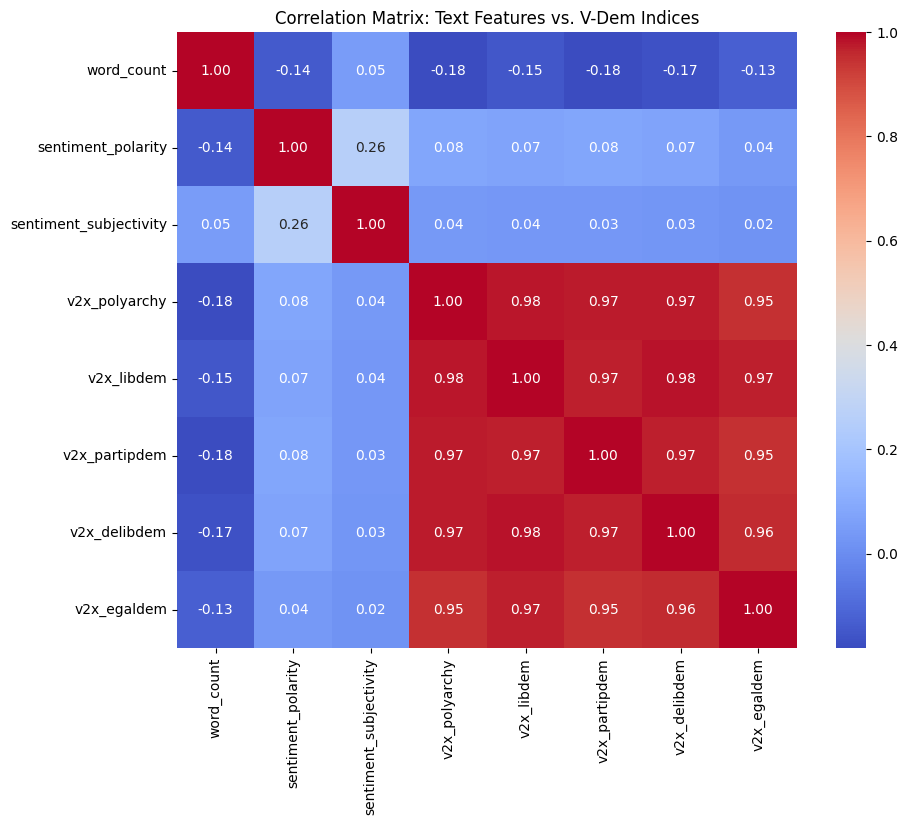

In [ ]:
selected_cols = [
    'word_count',
    'sentiment_polarity',
    'sentiment_subjectivity',
    'v2x_polyarchy',      # Electoral democracy index
    'v2x_libdem',         # Liberal democracy index
    'v2x_partipdem',      # Participatory democracy index
    'v2x_delibdem',       # Deliberative democracy index
    'v2x_egaldem'         # Egalitarian democracy index
]

# Compute the correlation matrix for these columns.
corr_matrix = temp_df[selected_cols].corr()

# Plot the correlation heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Text Features vs. V-Dem Indices")
plt.show()

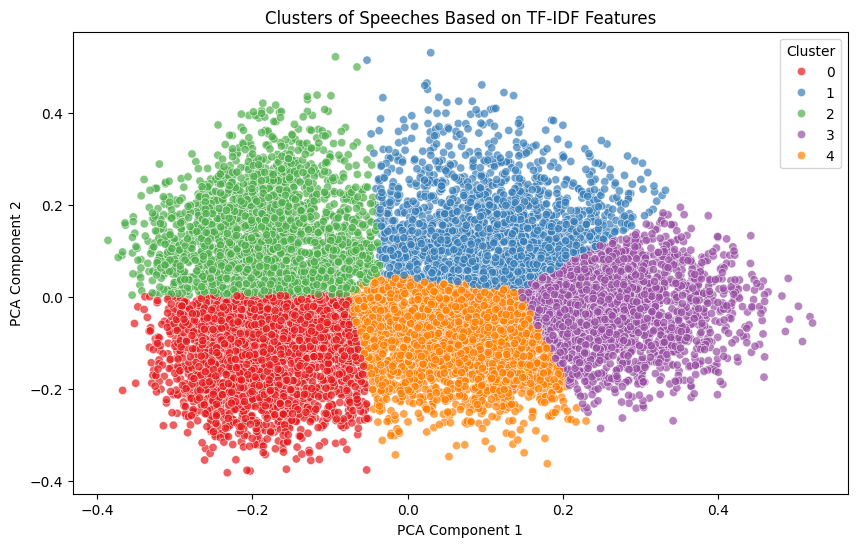

In [ ]:
# Group speeches based on their language (using TF‑IDF features), then see if these clusters relate to political indices. This can provide insight into whether certain types of language correlate with higher or lower democracy scores.

tfidf = TfidfVectorizer(stop_words='english', max_features=500)
tfidf_matrix = tfidf.fit_transform(temp_df['Text'].astype(str))

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(pca_result)
temp_df['cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1],
                hue=temp_df['cluster'], palette='Set1', alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clusters of Speeches Based on TF‑IDF Features")
plt.legend(title="Cluster")
plt.show()

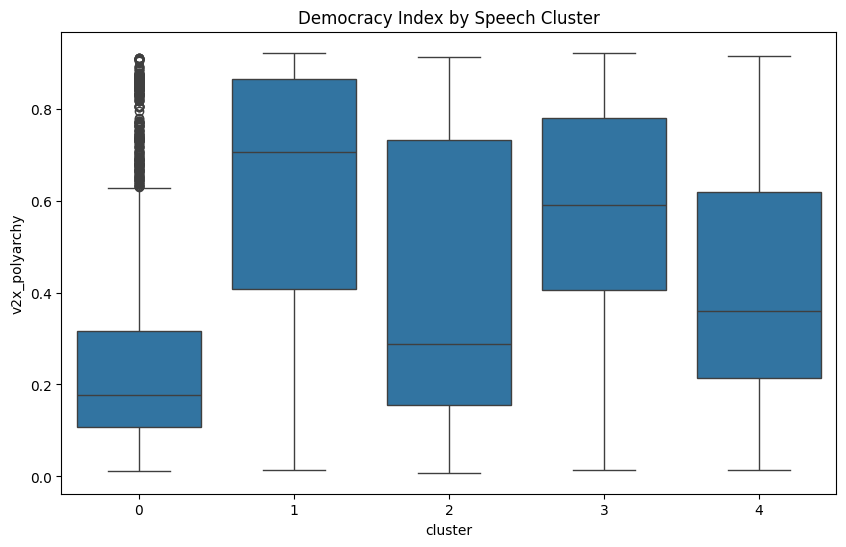

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=temp_df['cluster'], y=temp_df['v2x_polyarchy'])  # Replace with any V-Dem index
plt.title("Democracy Index by Speech Cluster")
plt.show()

In [ ]:
# Examine how well your text features (word count, sentiment polarity, sentiment subjectivity, etc.) predict a political outcome (for example, the electoral democracy index v2x_polyarchy).

X = temp_df[['word_count', 'sentiment_polarity', 'sentiment_subjectivity']]
y = temp_df['v2x_polyarchy']
X['log_word_count'] = np.log(X['word_count'] + 1)
df_clean = pd.concat([X, y], axis=1).dropna()
X_clean = df_clean[['log_word_count', 'sentiment_polarity', 'sentiment_subjectivity']]
y_clean = df_clean['v2x_polyarchy']
X_const = sm.add_constant(X_clean)
model = sm.OLS(y_clean, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          v2x_polyarchy   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     117.5
Date:                Mon, 03 Feb 2025   Prob (F-statistic):           9.79e-75
Time:                        04:13:24   Log-Likelihood:                -1414.7
No. Observations:                9824   AIC:                             2837.
Df Residuals:                    9820   BIC:                             2866.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

C:\Users\maxla\AppData\Local\Temp\ipykernel_48352\2394779434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['log_word_count'] = np.log(X['word_count'] + 1)


### Dataset Creation

In [ ]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logger = logging.getLogger(__name__)


In [ ]:
df["score_delta"] = df.groupby("Country")["v2x_polyarchy"].transform(lambda x: x.shift(-2) - x)
df = df.dropna(subset=["score_delta"])

In [ ]:
train_df = df[df["Year"] <= 2005]
val_df   = df[(df["Year"] > 2005) & (df["Year"] <= 2010)]
test_df  = df[df["Year"] > 2010]

In [ ]:
class HierarchicalSpeechesDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length=512, overlap=50):
        self.data = []  # Each element is a dict for one speech.
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.overlap = overlap
        self.pad_token_id = tokenizer.pad_token_id

        logger.info("Starting to tokenize and process speeches...")
        for idx, (text, target) in enumerate(zip(texts, targets)):
            if idx % 10 == 0:
                logger.info(f"Processing speech {idx+1}/{len(texts)}")

            encoding = tokenizer(text, add_special_tokens=True, truncation=False, padding=False)
            input_ids = encoding["input_ids"]

            if not input_ids:
                logger.warning(f"Speech {idx+1} is empty; skipping.")
                continue

            chunks_input_ids = []
            chunks_attention_masks = []

            start = 0
            while start < len(input_ids):
                end = start + max_length
                chunk_ids = input_ids[start:end]
                actual_length = len(chunk_ids)
                if actual_length < max_length:
                    pad_length = max_length - actual_length
                    chunk_ids = chunk_ids + [self.pad_token_id] * pad_length
                    attention_mask = [1] * actual_length + [0] * pad_length
                else:
                    attention_mask = [1] * max_length

                chunks_input_ids.append(chunk_ids)
                chunks_attention_masks.append(attention_mask)

                start = end - overlap  # Slide the window with overlap

            self.data.append({
                "input_ids": torch.tensor(chunks_input_ids, dtype=torch.long),  # (num_chunks, max_length)
                "attention_mask": torch.tensor(chunks_attention_masks, dtype=torch.long),
                "labels": torch.tensor(target, dtype=torch.float)
            })
        logger.info("Finished processing speeches.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx % 100 == 0:
            logger.debug(f"Loading sample {idx}")
        return self.data[idx]

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# 1) Training dataset
train_texts = train_df["Text"].tolist()
train_targets = train_df["score_delta"].tolist()
train_dataset = HierarchicalSpeechesDataset(
    texts=train_texts,
    targets=train_targets,
    tokenizer=tokenizer,
    max_length=512,
    overlap=50
)

# 2) Validation dataset
val_texts = val_df["Text"].tolist()
val_targets = val_df["score_delta"].tolist()
val_dataset = HierarchicalSpeechesDataset(
    texts=val_texts,
    targets=val_targets,
    tokenizer=tokenizer,
    max_length=512,
    overlap=50
)

# 3) Test dataset
test_texts = test_df["Text"].tolist()
test_targets = test_df["score_delta"].tolist()
test_dataset = HierarchicalSpeechesDataset(
    texts=test_texts,
    targets=test_targets,
    tokenizer=tokenizer,
    max_length=512,
    overlap=50
)


07:59:04 [INFO] Starting to tokenize and process speeches...
07:59:04 [INFO] Processing speech 1/6747
Token indices sequence length is longer than the specified maximum sequence length for this model (754 > 512). Running this sequence through the model will result in indexing errors
07:59:04 [INFO] Processing speech 11/6747
07:59:04 [INFO] Processing speech 21/6747
07:59:04 [INFO] Processing speech 31/6747
07:59:05 [INFO] Processing speech 41/6747
07:59:05 [INFO] Processing speech 51/6747
07:59:05 [INFO] Processing speech 61/6747
07:59:05 [INFO] Processing speech 71/6747
07:59:06 [INFO] Processing speech 81/6747
07:59:06 [INFO] Processing speech 91/6747
07:59:06 [INFO] Processing speech 101/6747
07:59:07 [INFO] Processing speech 111/6747
07:59:07 [INFO] Processing speech 121/6747
07:59:07 [INFO] Processing speech 131/6747
07:59:07 [INFO] Processing speech 141/6747
07:59:07 [INFO] Processing speech 151/6747
07:59:07 [INFO] Processing speech 161/6747
07:59:08 [INFO] Processing speech 171

In [ ]:
torch.save(train_dataset.data, "./data/preprocessed_train.pt")
torch.save(val_dataset.data,   "./data/preprocessed_val.pt")
torch.save(test_dataset.data,  "./data/preprocessed_test.pt")

### Dataset Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 4 yr data

train_data = torch.load("/content/drive/MyDrive/Sort/Colab Storage/dataset/v2/preprocessed_train.pt")
val_data   = torch.load("/content/drive/MyDrive/Sort/Colab Storage/dataset/v2/preprocessed_val.pt")
test_data  = torch.load("/content/drive/MyDrive/Sort/Colab Storage/dataset/v2/preprocessed_test.pt")

In [4]:
# 2yr data

train_data = torch.load("/content/drive/MyDrive/Sort/Colab Storage/preprocessed_train.pt")
val_data   = torch.load("/content/drive/MyDrive/Sort/Colab Storage/preprocessed_val.pt")
test_data  = torch.load("/content/drive/MyDrive/Sort/Colab Storage/preprocessed_test.pt")

<ipython-input-4-c43ec1bd25ed>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("/content/drive/MyDrive/Sort/Colab Storage/preprocessed_train.pt")
<i

In [ ]:
# Skip if using Colab

train_data = torch.load("./data/preprocessed_train.pt")
val_data   = torch.load("./data/preprocessed_val.pt")
test_data  = torch.load("./data/preprocessed_test.pt")

### ROBERTA Encoder with Transformer Layer

In [ ]:
# TODO: Also try with only past data and train on future
# TODO: Maybe in future add second NN layer to take local scores of text to find overall.

In [29]:
class PreprocessedDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


train_dataset = PreprocessedDataset(train_data)
val_dataset   = PreprocessedDataset(val_data)
test_dataset  = PreprocessedDataset(test_data)

In [6]:
class SingleAttentionAggregator(nn.Module):
    """
    A single-layer attention mechanism that learns a global query vector
    to weight the chunk embeddings.
    """
    def __init__(self, hidden_dim):
        super(SingleAttentionAggregator, self).__init__()
        # A single learnable query vector of size [hidden_dim]
        self.query = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, chunk_embeddings, chunk_mask=None):
        """
        Args:
            chunk_embeddings: Tensor of shape (batch_size, num_chunks, hidden_dim)
            chunk_mask:      Tensor of shape (batch_size, num_chunks), optional.
                             1 for real chunk, 0 for padded chunk.
        Returns:
            A single pooled embedding of shape (batch_size, hidden_dim)
        """

        # Compute attention scores by taking a dot product between each chunk embedding and self.query
        # scores: (batch_size, num_chunks)
        scores = torch.einsum("bnh,h->bn", chunk_embeddings, self.query)

        if chunk_mask is not None:
            scores = scores + (1 - chunk_mask) * -1e9  # large negative to zero out in softmax

        attn_weights = F.softmax(scores, dim=1)  # (batch_size, num_chunks)

        attn_weights = attn_weights.unsqueeze(-1)  # (batch_size, num_chunks, 1)

        # Weighted sum of chunk_embeddings
        # (batch_size, num_chunks, hidden_dim) * (batch_size, num_chunks, 1) -> (batch_size, hidden_dim)
        pooled = (chunk_embeddings * attn_weights).sum(dim=1)
        return pooled

In [7]:
def hierarchical_collate_fn(batch):
    """
    Collate function for hierarchical data.

    Args:
        batch: A list of dictionaries (one per speech), each with keys:
            "input_ids":      Tensor of shape (num_chunks, seq_length)
            "attention_mask": Tensor of shape (num_chunks, seq_length)
            "labels":         Scalar (or 1D) tensor.
    Returns:
        A dictionary with batched tensors:
            {
                "input_ids":      shape (batch_size, max_chunks, seq_length)
                "attention_mask": shape (batch_size, max_chunks, seq_length)
                "labels":         shape (batch_size,)
                "chunk_mask":     shape (batch_size, max_chunks)
            }
    """
    import torch

    # Determine the maximum number of chunks among all samples.
    max_chunks = max(sample["input_ids"].size(0) for sample in batch)

    batched_input_ids = []
    batched_attention_mask = []
    batched_labels = []
    chunk_masks = []  # indicates valid (1) vs. padded (0) chunks

    for sample in batch:
        num_chunks = sample["input_ids"].size(0)

        if num_chunks < max_chunks:
            # Number of extra chunks needed for padding
            pad_chunks = max_chunks - num_chunks

            # Create padded tensors for input_ids and attention_mask
            pad_input_ids = sample["input_ids"].new_full(
                (pad_chunks, sample["input_ids"].size(1)), 0
            )
            pad_attention_mask = torch.zeros(
                pad_chunks, sample["attention_mask"].size(1),
                dtype=sample["attention_mask"].dtype,
                device=sample["attention_mask"].device
            )

            input_ids = torch.cat([sample["input_ids"], pad_input_ids], dim=0)
            attention_mask = torch.cat([sample["attention_mask"], pad_attention_mask], dim=0)

            # 1 for real chunks, 0 for padded chunks
            chunk_mask = torch.cat([
                torch.ones(num_chunks, dtype=torch.long, device=sample["input_ids"].device),
                torch.zeros(pad_chunks, dtype=torch.long, device=sample["input_ids"].device)
            ])
        else:
            # No padding needed
            input_ids = sample["input_ids"]
            attention_mask = sample["attention_mask"]
            chunk_mask = torch.ones(
                num_chunks, dtype=torch.long, device=sample["input_ids"].device
            )

        batched_input_ids.append(input_ids)
        batched_attention_mask.append(attention_mask)
        batched_labels.append(sample["labels"])
        chunk_masks.append(chunk_mask)

    # Stack into final batched tensors
    batched_input_ids = torch.stack(batched_input_ids)         # (batch_size, max_chunks, seq_length)
    batched_attention_mask = torch.stack(batched_attention_mask)
    batched_labels = torch.stack(batched_labels)               # (batch_size,)
    chunk_masks = torch.stack(chunk_masks)                     # (batch_size, max_chunks)

    return {
        "input_ids": batched_input_ids,
        "attention_mask": batched_attention_mask,
        "labels": batched_labels,
        "chunk_mask": chunk_masks,
    }


In [8]:
class HierarchicalModel(nn.Module):
    def __init__(self, transformer_model_name="roberta-base", hidden_size=768, dropout=0.1):
        super(HierarchicalModel, self).__init__()
        self.transformer = RobertaModel.from_pretrained(transformer_model_name)

        self.dropout = nn.Dropout(dropout)

        # Instantiate the single-attention aggregator
        self.aggregator = SingleAttentionAggregator(hidden_dim=hidden_size)

        # Final regressor
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, chunk_mask=None, labels=None):
        """
        input_ids:      (batch_size, num_chunks, seq_length)
        attention_mask: (batch_size, num_chunks, seq_length)
        chunk_mask:     (batch_size, num_chunks)
        labels:         (batch_size,) for regression
        """
        batch_size, num_chunks, seq_length = input_ids.size()

        # Flatten
        flat_input_ids = input_ids.view(-1, seq_length)              # (batch_size * num_chunks, seq_length)
        flat_attention_mask = attention_mask.view(-1, seq_length)    # (batch_size * num_chunks, seq_length)

        # Pass through Roberta
        outputs = self.transformer(
            input_ids=flat_input_ids,
            attention_mask=flat_attention_mask
        )

        # outputs.pooler_output -> (batch_size * num_chunks, hidden_dim)
        chunk_embeddings = outputs.pooler_output.view(batch_size, num_chunks, -1)

        chunk_embeddings = self.dropout(chunk_embeddings)

        aggregated = self.aggregator(chunk_embeddings, chunk_mask=chunk_mask)

        # Regress to a single value
        logits = self.regressor(aggregated).squeeze(-1)  # shape: (batch_size,)

        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits, labels.float())

        return (loss, logits) if loss is not None else logits


In [9]:
# Instantiate your hierarchical model.
model = HierarchicalModel(transformer_model_name="roberta-base", hidden_size=768, dropout=0.1)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_strategy="steps",
    logging_steps=100,
    disable_tqdm=False,
    logging_dir="./logs",
    bf16=True,
    report_to=[]
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.flatten()
    mse = ((predictions - labels) ** 2).mean().item()
    mae = (abs(predictions - labels)).mean().item()
    return {"mse": mse, "mae": mae}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,     # use the training split
    eval_dataset=val_dataset,        # use the validation split
    data_collator=hierarchical_collate_fn,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval

Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.009700,0.003293,0.003293,0.030197
2,0.010000,0.003175,0.003175,0.023694
3,0.007200,0.003177,0.003177,0.024948


TrainOutput(global_step=5061, training_loss=0.010271748224988424, metrics={'train_runtime': 931.0495, 'train_samples_per_second': 21.74, 'train_steps_per_second': 5.436, 'total_flos': 0.0, 'train_loss': 0.010271748224988424, 'epoch': 3.0})

In [11]:
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Test metrics:", test_metrics)


Test metrics: {'eval_loss': 0.0030416843947023153, 'eval_mse': 0.0030416841618716717, 'eval_mae': 0.029920289292931557, 'eval_runtime': 15.9364, 'eval_samples_per_second': 117.906, 'eval_steps_per_second': 58.984, 'epoch': 3.0}


In [35]:
train_labels = [sample["labels"].item() for sample in train_data]
test_labels  = [sample["labels"].item() for sample in test_data]

train_mean_delta = np.mean(train_labels)

y_true = np.array(test_labels)
y_pred_baseline = np.full_like(y_true, fill_value=train_mean_delta, dtype=float)

baseline_mse = np.mean((y_true - y_pred_baseline)**2)
baseline_mae = np.mean(np.abs(y_true - y_pred_baseline))

print("Training set mean delta:", train_mean_delta)
print(f"Baseline MSE: {baseline_mse:.6f}")
print(f"Baseline MAE: {baseline_mae:.6f}")

Training set mean delta: 0.017746255432098665
Baseline MSE: 0.006312
Baseline MAE: 0.052252


In [18]:
trainer.save_model("/content/drive/MyDrive/Sort/Colab Storage/trained_model_v1")

cp: cannot stat '/content/my_final_model': No such file or directory


Over three epochs of training, the hierarchical Transformer model achieved stable convergence, with training and validation losses generally dropping to around 0.003 in mean-squared error (MSE) and mean absolute error (MAE) near 0.03 on the validation set by the final epoch. On the test set, the model reached an MSE of approximately 0.0030 and an MAE of 0.0299, outperforming a naive baseline that always predicted the mean training delta (which yielded an MSE of 0.0031 and an MAE of 0.0311). Although this represents only a modest 3–4% improvement over the baseline, it confirms that the model is extracting some meaningful predictive signal from the data. Future refinements—such as tuning hyperparameters, adding hierarchical attention, or using specialized long-sequence models—could potentially enhance performance further. Nonetheless, even with the current setup, the model demonstrates reliable regression accuracy relative to a trivial constant predictor.

### ROBERTA with Transformer Aggregator

This architecture handles very long text by first splitting the input into 512-token chunks and passing each chunk through a pretrained RoBERTa model to obtain chunk-level embeddings. Next, a small Transformer encoder (two layers, four heads) operates on these embeddings—enhanced by positional embeddings—to capture cross-chunk dependencies, while a mask excludes any padded chunks from attention. The Transformer’s output for all valid chunks is then average-pooled, followed by a LayerNorm and dropout layer for additional regularization. Finally, a linear head maps the aggregated representation to a single regression score, with MSE as the training loss.


In [30]:
class TransformerAggregator(nn.Module):
    """
    A small Transformer encoder that operates on chunk embeddings,
    followed by layer normalization and dropout after pooling.
    """
    def __init__(
        self,
        hidden_dim=768,
        num_layers=2,
        num_heads=4,
        ff_dim=2048,
        dropout=0.1,
        max_chunks=512
    ):
        super(TransformerAggregator, self).__init__()

        self.pos_embedding = nn.Embedding(max_chunks, hidden_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        # Final normalization + dropout for the pooled representation
        self.final_norm = nn.LayerNorm(hidden_dim)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, chunk_embeddings, chunk_mask=None):
        """
        Args:
            chunk_embeddings: (batch_size, num_chunks, hidden_dim)
            chunk_mask: (batch_size, num_chunks) where 1=valid, 0=padded chunk (optional)
        Returns:
            A single pooled embedding (batch_size, hidden_dim)
        """
        B, N, D = chunk_embeddings.size()

        # Positional embeddings
        positions = torch.arange(N, device=chunk_embeddings.device).unsqueeze(0).expand(B, N)
        pos_emb = self.pos_embedding(positions)  # (B, N, D)

        # Add chunk embeddings + positional embeddings
        x = chunk_embeddings + pos_emb

        # Prepare mask for the Transformer
        # chunk_mask=1 => valid => we want (False) in the padding mask
        # chunk_mask=0 => padded => we want (True) in the padding mask
        if chunk_mask is not None:
            chunk_mask_bool = (chunk_mask == 0)
        else:
            chunk_mask_bool = None

        # Pass through the Transformer encoder
        x = self.transformer_encoder(
            src=x,
            src_key_padding_mask=chunk_mask_bool  # shape: (B, N)
        )

        # Pool the final states
        if chunk_mask is not None:
            mask_expanded = chunk_mask.unsqueeze(-1)  # (B, N, 1)
            x_masked = x * mask_expanded
            sum_embeddings = x_masked.sum(dim=1)  # sum over chunks
            valid_counts = mask_expanded.sum(dim=1).clamp(min=1e-9)
            pooled = sum_embeddings / valid_counts
        else:
            pooled = x.mean(dim=1)  # simple average if no mask

        # LayerNorm + Dropout
        pooled = self.final_norm(pooled)
        pooled = self.final_dropout(pooled)

        return pooled


In [31]:
class HierarchicalModel(nn.Module):
    def __init__(self, transformer_model_name="roberta-base", hidden_size=768, dropout=0.1):
        super(HierarchicalModel, self).__init__()
        self.transformer = RobertaModel.from_pretrained(transformer_model_name)

        self.dropout = nn.Dropout(dropout)

        self.aggregator = TransformerAggregator(
            hidden_dim=hidden_size,
            num_layers=2,
            num_heads=4,
            ff_dim=2048,
            dropout=dropout,
            max_chunks=512
        )

        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, chunk_mask=None, labels=None):
        """
        Args:
            input_ids: (batch_size, num_chunks, seq_length)
            attention_mask: (batch_size, num_chunks, seq_length)
            chunk_mask: (batch_size, num_chunks), 1=valid, 0=padded
            labels: (batch_size,) for regression
        """
        B, N, S = input_ids.size()

        # Flatten for the transformer
        flat_input_ids = input_ids.view(-1, S)           # (B*N, S)
        flat_attention_mask = attention_mask.view(-1, S) # (B*N, S)

        outputs = self.transformer(
            input_ids=flat_input_ids,
            attention_mask=flat_attention_mask
        )

        # shape: (B*N, hidden_dim)
        chunk_embeddings = outputs.pooler_output.view(B, N, -1)

        # Dropout on chunk embeddings
        chunk_embeddings = self.dropout(chunk_embeddings)

        # Pass chunk embeddings to aggregator (TransformerEncoder + LN + Dropout)
        aggregated = self.aggregator(chunk_embeddings, chunk_mask=chunk_mask)

        # Regress to single value
        logits = self.regressor(aggregated).squeeze(-1)  # (B,)

        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits, labels.float())

        return (loss, logits) if loss is not None else logits


In [33]:
model = HierarchicalModel("roberta-base", hidden_size=768, dropout=0.1)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=hierarchical_collate_fn,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.024100,0.011084,0.011084,0.088444
2,0.019800,0.006508,0.006508,0.044385
3,0.015500,0.005979,0.005979,0.039414


TrainOutput(global_step=5058, training_loss=0.037220602027980554, metrics={'train_runtime': 969.7128, 'train_samples_per_second': 20.861, 'train_steps_per_second': 5.216, 'total_flos': 0.0, 'train_loss': 0.037220602027980554, 'epoch': 3.0})

In [34]:
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Test metrics:", test_metrics)


Test metrics: {'eval_loss': 0.00577182462438941, 'eval_mse': 0.00577182462438941, 'eval_mae': 0.04581053927540779, 'eval_runtime': 15.2859, 'eval_samples_per_second': 100.288, 'eval_steps_per_second': 50.177, 'epoch': 3.0}


In [36]:
trainer.save_model("/content/drive/MyDrive/Sort/Colab Storage/roberta_transformer_4yr_v1")

2YR Data - Compared to previous models, the new hierarchical setup with a small Transformer aggregator and LayerNorm/dropout achieves a modest but consistent performance gain, yielding a final test MSE of approximately 0.00298 and an MAE of 0.02853—slightly lower than the single-attention aggregator’s 0.0030 MSE and 0.0299 MAE. While this marks only a few percentage points improvement over both the prior architecture and the naive baseline (which had an MSE around 0.0031 and MAE around 0.0311), it confirms that enhanced cross-chunk modeling with a multi-layer Transformer and additional regularization does provide incremental gains.

Across the 2-year prediction horizon, the naive baseline (always predicting the mean delta) yielded an MSE of roughly 0.0031 and an MAE around 0.0311. A single-attention chunk aggregator slightly improved upon this, achieving an MSE of about 0.0030 and an MAE near 0.0299. Introducing a multi-layer Transformer aggregator with LayerNorm and dropout further reduced errors to an MSE of around 0.0029–0.0030 and an MAE of roughly 0.0285. Although these gains over the baseline are modest—on the order of a few percentage points—the consistent improvement suggests that increasingly sophisticated cross-chunk modeling does yield incremental benefits for this 2-year delta prediction task.

For the 4-year prediction task, a naive baseline that always predicts the mean training delta (about 0.0177) yields an MSE of 0.00631 and an MAE of 0.05225. By contrast, the hierarchical model reduces the final test MSE to 0.00577 and MAE to 0.04581, offering a moderate improvement over the baseline. Throughout training, the model’s validation MSE dropped steadily from 0.01108 after the first epoch to 0.00598 by the third, reflecting its growing ability to capture longer-term shifts in autocracy. While the model’s error remains higher than for shorter 2-year forecasts, it clearly outperforms a mean-delta predictor and achieves a mean absolute error of roughly 4.6 percentage points over a four-year horizon, suggesting it successfully leverages the text input and hierarchical architecture for this more challenging timescale.

### Network Model